In [154]:
import pandas as pd
import numpy as np
from datetime import datetime
df = pd.read_excel(
    'INPUTS.xlsx',
    usecols=['Скважина', 'Дата', 'Пластовое давление'],
    dtype={'Скважина': np.string_, 'Дата': np.datetime64, 'c': np.float32}
)
df.head(10)

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Скважина,Дата,Пластовое давление
0,b'1000',2022-05-01,154.0
1,b'1000',2022-05-02,153.8
2,b'1000',2022-05-03,153.7
3,b'1000',2022-05-04,153.6
4,b'1000',2022-05-05,153.5
5,b'1000',2022-05-06,153.3
6,b'1000',2022-05-07,153.2
7,b'1000',2022-05-08,153.1
8,b'1000',2022-05-09,153.0
9,b'1000',2022-05-10,152.8


In [ ]:
# mean = df['Пластовое давление'].mean()
# std = df['Пластовое давление'].std()

# print('mean: ', mean)
# print('std: ', std)

# df['Пластовое давление'] = (df['Пластовое давление'] - mean) / std

mean:  123.48736498834552
std:  36.59383003612493


In [85]:
df_timeseries = df.groupby(['Скважина'])['Пластовое давление'].apply(list).reset_index(name='Динамика давления')
df_timeseries.head()

,Скважина,Динамика давления
0,b'1000',"[154.0, 153.8, 153.7, 153.6, 153.5, 153.3, 153..."
1,b'1001',"[127.4, 127.3, 127.3, 127.3, 127.2, 127.2, 127..."
2,b'1003',"[119.8, 119.8, 119.8, 119.7, 119.7, 119.6, 119..."
3,b'1004',"[141.0, 140.8, 140.6, 140.5, 140.3, 140.2, 140..."
4,b'1007',"[99.9, 99.8, 99.7, 99.7, 99.6, 99.5, 99.5, 99...."


In [86]:
df_timeseries.shape

(224, 2)

In [87]:
def make_sublists(source, size=10):
    return None if len(source) <= 10 else [
        [source[right_end-size : right_end], source[right_end]]
        for right_end in range(10, len(source), 1)
    ]

In [88]:
make_sublists(list(range(1,30,1)))

[[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 11],
 [[2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 12],
 [[3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 13],
 [[4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 14],
 [[5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 15],
 [[6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 16],
 [[7, 8, 9, 10, 11, 12, 13, 14, 15, 16], 17],
 [[8, 9, 10, 11, 12, 13, 14, 15, 16, 17], 18],
 [[9, 10, 11, 12, 13, 14, 15, 16, 17, 18], 19],
 [[10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 20],
 [[11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 21],
 [[12, 13, 14, 15, 16, 17, 18, 19, 20, 21], 22],
 [[13, 14, 15, 16, 17, 18, 19, 20, 21, 22], 23],
 [[14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 24],
 [[15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 25],
 [[16, 17, 18, 19, 20, 21, 22, 23, 24, 25], 26],
 [[17, 18, 19, 20, 21, 22, 23, 24, 25, 26], 27],
 [[18, 19, 20, 21, 22, 23, 24, 25, 26, 27], 28],
 [[19, 20, 21, 22, 23, 24, 25, 26, 27, 28], 29]]

In [89]:
input_seq_size = 10
dataset = df_timeseries['Динамика давления'] \
    .apply(lambda x: make_sublists(x, input_seq_size)) \
    .dropna() \
    .reset_index(name='shifts') \
    ['shifts'] \
    .tolist()

In [90]:
dataset_length = sum([len(group) for group in dataset])
dataset_length

89141

In [91]:
X = np.zeros(shape=(dataset_length, input_seq_size), dtype=np.float32)
Y = np.zeros(shape=(dataset_length), dtype=np.float32)

i = 0
for group in dataset:
    for entry in group:
        X[i] = entry[0]
        Y[i] = entry[1]
        i+=1

print(X.shape)
print(Y.shape)
print(X[0])
print(Y[0])

(89141, 10)
(89141,)
[154.  153.8 153.7 153.6 153.5 153.3 153.2 153.1 153.  152.8]
152.7


In [92]:
train_size = int(X.shape[0] * 0.5)

X_train, X_val = X[:train_size], X[train_size:]
Y_train, Y_val = Y[:train_size], Y[train_size:]
X_train.shape, X_val.shape

((44570, 10), (44571, 10))

In [175]:
import tensorflow as tf

model = tf.keras.Sequential(
    [
        tf.keras.layers.LSTM(32, input_shape=(input_seq_size, 1), name='lstm'),
        tf.keras.layers.Dense(1, name='dense')
    ],
    name='sequential'
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [94]:
!mkdir -p ./model_weights/

In [174]:
model.compile(
    loss='mse',
    optimizer='adam',
    metrics=[tf.keras.metrics.R2Score()],
)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./model_weights/checkpoint',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)
history = model.fit(
    X_train,
    Y_train,
    batch_size=512,
    epochs=300,
    validation_data=(X_val, Y_val),
    callbacks=[
        early_stopping,
        model_checkpoint_callback,
    ],
)

Epoch 1/300


InvalidArgumentError: ignored

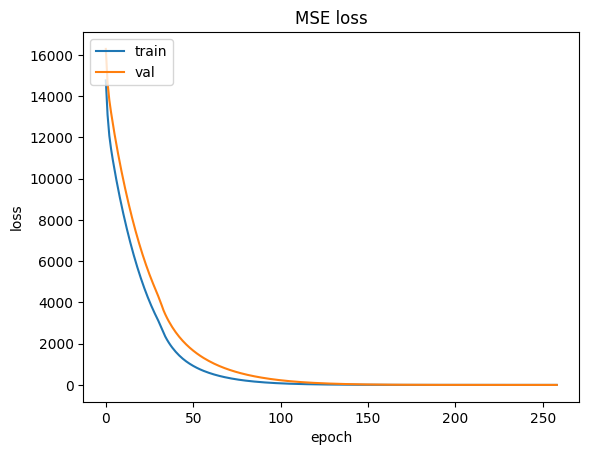

In [122]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MSE loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

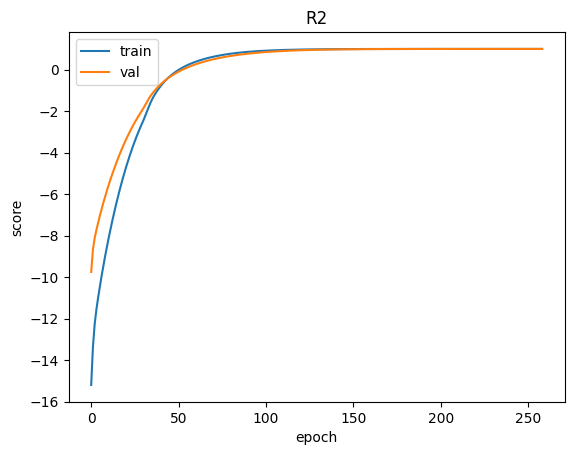

In [123]:
plt.plot(history.history['r2_score'])
plt.plot(history.history['val_r2_score'])
plt.title('R2')
plt.ylabel('score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [128]:
model.load_weights('./model_weights/checkpoint')
model.save('lstm_model_unnormalized_best2.keras')

In [124]:
print(np.expand_dims(df_timeseries['Динамика давления'][0][:10], axis=(0,-1)))
print(np.expand_dims(df_timeseries['Динамика давления'][0][10], axis=(0,-1)))

[[[154. ]
  [153.8]
  [153.7]
  [153.6]
  [153.5]
  [153.3]
  [153.2]
  [153.1]
  [153. ]
  [152.8]]]
[[152.7]]


In [129]:
model.predict(np.expand_dims(df_timeseries['Динамика давления'][0][:10], axis=(0)))

1/1 [==============================] - 0s 17ms/step


array([[152.68967]], dtype=float32)

In [167]:
def predict(pressure_dynamics):
    model.layers[0].reset_states()
    predict_length = 20
    initial_data = pressure_dynamics[:10]
    preds = []
    data = np.expand_dims(pressure_dynamics[:10], axis=0)
    for _ in range(predict_length):
        prediction = np.round(model.predict(data, verbose=0), decimals=1)
        preds.append(np.squeeze(prediction).item())
        data = np.concatenate((data[..., 1:], prediction), axis=-1)
    return preds

In [168]:
df_timeseries['first10'] = df_timeseries['Динамика давления'].apply(lambda x: x[:10])
df_timeseries['predicted_next_20'] = df_timeseries['Динамика давления'].apply(predict)
df_timeseries['real_next_20'] = df_timeseries['Динамика давления'].apply(lambda x: x[10:30])
df_timeseries[['Скважина', 'first10', 'predicted_next_20', 'real_next_20']].head()

AttributeError: ignored

In [160]:
df_timeseries[['Скважина', 'first10', 'predicted_next_20', 'real_next_20']].head()

,Скважина,first10,predicted_next_20,real_next_20
0,b'1000',"[154.0, 153.8, 153.7, 153.6, 153.5, 153.3, 153...","[152.6999969482422, 152.5, 152.39999389648438,...","[152.7, 152.6, 152.5, 152.3, 152.2, 152.1, 152..."
1,b'1001',"[127.4, 127.3, 127.3, 127.3, 127.2, 127.2, 127...","[127.0, 126.9000015258789, 126.80000305175781,...","[127.0, 127.0, 126.9, 126.9, 126.8, 126.8, 126..."
2,b'1003',"[119.8, 119.8, 119.8, 119.7, 119.7, 119.6, 119...","[119.5, 119.5, 119.5, 119.5, 119.5, 119.5, 119...","[119.4, 119.4, 119.4, 119.3, 119.3, 119.3, 119..."
3,b'1004',"[141.0, 140.8, 140.6, 140.5, 140.3, 140.2, 140...","[139.39999389648438, 139.3000030517578, 139.19...","[139.3, 139.2, 139.0, 138.9, 138.7, 138.5, 138..."
4,b'1007',"[99.9, 99.8, 99.7, 99.7, 99.6, 99.5, 99.5, 99....","[99.19999694824219, 99.19999694824219, 99.1999...","[99.2, 99.1, 99.1, 99.0, 99.0, 98.9, 98.8, 98...."


In [161]:
df_timeseries.to_csv('output.csv', index=False)